# **CS 484 Final Project: Post-training Network Calibration in Classification Models.**

# Name: Utkarsh Anand, Student ID: 20859191, Email: u3anand@uwaterloo.ca

# Abstract

I have based my project on this paper : https://arxiv.org/pdf/1706.04599.

Confidence calibration in neural networks is crucial for the reliability of probability estimates they provide, which are supposed to reflect true likelihoods of correctness. This aspect of neural network performance is especially important in domains where decisions must be made under uncertainty, such as in autonomous systems or medical diagnosis applications. The original paper indicates that ResNet architectures, when tested on CIFAR-100, exhibit significant calibration errors. The best strategy for calibration was found to be temperature scaling throughout all experiments. Selective temperature scaling was introduced in this paper: https://arxiv.org/pdf/2212.12053 for calibration of semantic segmentation models. The paper showed that selective temperature scaling actually outperforms temperature scaling for semantic segmentation models. 

This project evaluates the performance of ResNet18 and ResNet34 on CIFAR-100 using various post-training calibration methods, including histogram binning, temperature scaling, vector scaling, and matrix scaling. This project uses a split of 45,000 images for training and 5,000 for validation. The validation set is used to learn the parameters for calibration. My implementation of the mentioned methods have shown that vector/matrix scaling. My results show that vector scaling and matrix scaling, when combined with L2 regularization, can help to avoid overfit to the validation set — a common issue in the absence of regularization —but also potentially outperform the widely used temperature scaling method. Furthermore, I tested the applicability of selective temperature scaling which was originally proposed for segmentation tasks. The results also show that selective temperature scaling does not perform well compared to the other methods implemented. 

# Adapting ResNet for CIFAR-100

In this project, I adapted the ResNet18 and ResNet34 architectures specifically for CIFAR-100 by changing the initial convolution and pooling layers. CIFAR-100 images are relatively small, with dimensions of 32x32 pixels, in contrast to the larger ImageNet images that ResNet was originally designed to process. I replaced the standard 7x7 convolutional layer with a 3x3 layer and eliminated the max pooling step at the beginning of the network. This modification allows the network to preserve more spatial information in the early layers, which is needed for capturing the fine-grained details needed to differentiate among the 100 classes in CIFAR-100. By maintaining higher resolution at the start, the model can access more information. This enhanced my model accuracy significantly.

# Code Libraries








This project uses the following versions for code libraries
```
torch:       '2.2.0+cu121'
torchvision: '0.17.0+cu121'
numpy:       '1.26.3'
pandas:      '2.2.2'
sklearn:     '1.4.1.post1'
IPython:     '8.21.0'
matplotlib:  '3.8.2'
```
I have used the GPU for optimizers in this project, otherwise the operations are quite slow.

My CUDA versions are listed below:
```
CUDA version: 12.2
GPU: NVIDIA GeForce RTX 3050
Memory: 4096MiB
```
My laptop GPU was sufficient for this project.

I install torch and torchvision via this command:
```
pip install torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1 --index-url https://download.pytorch.org/whl/cu121
```

In [200]:
"""
This cell contains all the necessary imports needed for this project
"""
# torch - needed for tensor operators and optimizers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import os
import time

# numpy and matplotlib for plotting and general operations
import numpy as np
from matplotlib import pyplot as plt

# torchvision - needed for resnet
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# These are my libraries for creating models and plotting
from mylibs.models import get_resnet18_model, get_resnet34_model
from mylibs.plotting import plot_reliability_diagram, plot_confidence_histogram

# Pandas and Ipython are just used for display
import pandas as pd
from IPython.display import display

# sklearn is used in selective temperature scaling
from sklearn.metrics import accuracy_score, log_loss, brier_score_loss
from sklearn.ensemble import RandomForestClassifier

# Terminology

I used this paper: https://arxiv.org/pdf/1706.04599.pdf, focusing on multi-class classification for deep neural networks.

Suppose that a neural network $h$ is defined as : $h(X) = (\hat Y, \hat P)$, where $\hat Y$ is a class prediction and $\hat P$ is its associated confidence.

The definition for a perfect calibration:
$$ P ( \hat Y = Y | \hat P = p ) = p$$

where the probability is over the joint distribution. In all
practical settings, achieving perfect calibration is impossible. Additionally, the probability shown above cannot be computed using finitely many samples since $P$ is a continuous random variable.

To estimate the expected accuracy from finite samples, the idea is to group predictions into $M$ interval bins (each of size $\frac{1}{M}$). Let $B_m$ be the set of indices of samples whose prediction confidence falls into the interval $I_m = ( \frac{m-1}{M}, \frac{m}{M} ]$. The accuracty of $B_m$ is given by:

$$ acc(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \mathbf{1}(\hat y_i = y_i)$$

where $\hat y_i$ and $y_i$ are the predicted and true class labels for sample $i$. Note that $acc(B_m)$ is an unbiased and consistent estimator of $P ( \hat Y = Y | \hat P \in I_m)$. This is way of "discretizing" the defintion.

We can also define the average confident within bin $B_m$ as

$$ conf(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \hat p_i$$

where $\hat p_i$ is the confidence for sample $i$. Note that this basically represents the average confidence in that interval and hence we can define discrete "perfect" calibration as:

$$ acc(B_m) = conf(B_m)$$

The following metrics are used for measuring the calibration errors.

1. **Expected Calibration Error (ECE)**

Miscalibration can be defined as the difference in expection between confidence and accuracy.
$$ \mathbb{E}\left[\left|P(\hat Y = Y | \hat P = p) - p \right|\right]$$

Then we can a take a weighted average over M bins for this calibrations to get ECE.

$$ ECE = \sum_{m=1}^M \frac{|B_m|}{n} \left| acc(B_m) - conf(B_m) \right|$$

Here n in the number of samples. The difference between the accuracy in the bin and the average confidence of that bin represents a "gap".

2. **Classwise Expected Calibration Error (Classwise ECE)** 

The paper(using this metric from this paper: https://arxiv.org/pdf/1910.12656) shows that temperature scaling is not classwise calibrated, so we track this Error in other methods as well.

The Classwise ECE measures calibration error separately for each class and then averages these errors. This metric provides insight into how well-calibrated the model is for each individual class.

$$\text{Classwise ECE} = \frac{1}{C} \sum_{c=1}^C \sum_{m=1}^M \frac{|B_{m,c}|}{n_c} \left| \text{acc}(B_{m,c}) - \text{conf}(B_{m,c}) \right|$$

Here $C$ is the number of classes, $B_{m,c}$ is the set of indices of samples in class $c$ whose confidence falls into the interval $I_m$, $n_c$ is the number of samples in class $c$, $\text{acc}(B_{m,c})$ and $\text{conf}(B_{m,c})$ are the accuracy and confidence for bin $m$ and class $c$, respectively.

4. **Maximum Calibration Error (MCE)**

By not taking the weight average this simply calulates the worst-case deviation between confidence and accuracy.

$$ MCE = \max_{m \in \{1, ..., M\}} \left|acc(B_m) - conf(B_m)\right| $$

5. **Brier Score**
The Brier Score is a measure of the accuracy of probabilistic predictions. It is calculated as the mean squared difference between the predicted probabilities and the actual outcomes.

$$\text{Brier Score} = \frac{1}{n} \sum_{i=1}^n \sum_{c=1}^C (\hat{p}_{i,c} - \mathbf{1}(y_i = c))^2$$

where $\hat{p}_{i,c}$ is the predicted probability that sample $i$ belongs to class $c$, and $\mathbf{1}(y_i = c)$ is the indicator function that is 1 if $y_i = c$ and 0 otherwise.

I'm not sure how Brier Score needs to be interpreted, but I have included it for the sake of completeness of all error metrics.

In [201]:
"""
This cell contains the implementations of the above metrics. Note that they are implemented as Loss functions (nn.Modules) for ease of use.
"""

class ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    """
    def __init__(self, n_bins=10):
        super(ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, probs, labels):
        confidences, predictions = torch.max(probs, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=probs.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece.cpu().item()

class ClasswiseECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    """
    def __init__(self, n_bins=10, n_classes=10):
        super(ClasswiseECELoss, self).__init__()
        self.n_bins = n_bins
        self.n_classes = n_classes
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, probs, labels):
        confidences, predictions = torch.max(probs, 1)
        accuracies = predictions.eq(labels)

        classwise_ece = torch.zeros(1, device=probs.device)

        for j in range(self.n_classes):
            class_confidences = probs[:, j]
            class_labels = (labels == j).float()

            ece = torch.zeros(1, device=probs.device)
            
            for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
                in_bin = (class_confidences > bin_lower) & (class_confidences <= bin_upper)
                prop_in_bin = in_bin.float().mean()
                
                if prop_in_bin.item() > 0:
                    accuracy_in_bin = class_labels[in_bin].mean()
                    avg_confidence_in_bin = class_confidences[in_bin].mean()
                    ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

            classwise_ece += ece
            
        return (classwise_ece / self.n_classes).cpu().item()

class MCELoss(nn.Module):
    """
    Calculates the Maximum Calibration Error (MCE) of a model.
    MCE measures the maximum error in calibration across confidence bins.
    """
    def __init__(self, n_bins=10):
        super(MCELoss, self).__init__()
        self.bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = self.bin_boundaries[:-1]
        self.bin_uppers = self.bin_boundaries[1:]

    def forward(self, probs, labels):
        confidences, predictions = torch.max(probs, 1)
        accuracies = predictions.eq(labels)

        mce = torch.tensor(0.0, device=probs.device)  # Initialize MCE to zero
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculate |confidence - accuracy| in each bin
            in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                gap = torch.abs(avg_confidence_in_bin - accuracy_in_bin)
                mce = torch.max(mce, gap)

        return mce.cpu().item()

def brier_score(probs, labels):
    """
    Compute the Brier score for multi-class classification.
    """
    n_classes = probs.shape[1]
    true_one_hot = F.one_hot(labels, num_classes=n_classes).to(probs.dtype)
    squared_diff = (probs - true_one_hot) ** 2
    mean_brier_score = squared_diff.mean()
    return mean_brier_score

# General Evaluation Function

In [202]:
def evaluate(logits, labels, probs=None, n_bins=10, n_classes=100):
    """
    Evaluate model on the above metrics

    1. ECE
    2. Classwise ECE
    3. MCE
    4. Brier Score
    5. Accuracy
    """
    ece_loss = ECELoss(n_bins=n_bins)
    c_ece_loss = ClasswiseECELoss(n_bins=n_bins, n_classes=n_classes)
    mce_loss = MCELoss(n_bins=n_bins)

    if probs is None:
        probs = F.softmax(logits, dim=1)

    ece = ece_loss(probs, labels)
    c_ece = c_ece_loss(probs, labels)
    mce = mce_loss(probs, labels)
    # nll = log_loss(logits, labels)
    _, preds = probs.max(dim=1)
    accuracy = (preds == labels).float().mean().item()
    error = 1 - accuracy

    # Calculate Brier Score for each class and average
    # One-hot encode labels for Brier score calculation
    labels_one_hot = np.eye(n_classes)[labels]
    brier_scores = np.mean([brier_score_loss(labels_one_hot[:, i], probs[:, i])
                            for i in range(n_classes)])
    
    print(f"Accuracy: {accuracy * 100}%")
    print(f"Error: {error * 100}%")
    print(f"ECE: {ece * 100}%")
    print(f"classwise ECE: {c_ece * 100}%")
    print(f"MCE: {mce * 100}%")
    # print(f"Loss: {nll}")
    print(f"Brier: {brier_scores}")

# Calibration Techniques

# 1. Histogram Binning

All uncalibrated predictions are divided into M mutually exclusive bins $B_1, B_2, ..., B_M$. Each bin is assigned a calibrated score $\theta_m$, if $\hat p_i$ is assigned to the bin $B_m$, then the calibrated prediction is $\theta_m$. We define the bin boundaries $0 = a1 \leq a2 \leq ... \leq a_{M+1}$, each bin is defined by the interval $( a_m, a_{m+1} )$. According to paper, the bins are chosen to be equal length intervals. The predictions $\theta_i$ are chosen to minimize the bin-wise squared loss:
$$ \min_{\theta_i} \sum_{m=1}^{M} \sum_{i=1}^{n} \mathbb{1}(a_m \leq \hat p_i \le a_{m+1}) (\theta_m - y_i)^2$$

Given fixed bins boundaries, the solution to above results in $θ_m$ that correspond to the average number of positive-class samples in bin $B_m$.

This explanation is borrowed from the original paper.

In [203]:
class HistogramBinningCalibrator:
    def __init__(self, n_bins=10, n_classes=100):
        self.n_classes = n_classes
        self.n_bins = n_bins
        self.bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.calibrated_probs = torch.zeros(n_classes, n_bins)
    
    def fit(self, logits, labels):
        probs = F.softmax(logits, dim=1)
        for k in range(self.n_classes):
            # Treat class k as the positive class
            is_class_k = (labels == k).cpu().numpy()
            probs_k = probs[:, k].cpu().numpy()

            # Digitize probabilities for class k
            digitized = np.digitize(probs_k, self.bin_boundaries.numpy(), right=True) - 1
            digitized = np.clip(digitized, 0, self.n_bins - 1)

            # Calculate accuracy for each bin
            for i in range(self.n_bins):
                in_bin = (digitized == i)
                if np.sum(in_bin) > 0:
                    bin_accuracy = np.mean(is_class_k[in_bin])
                    self.calibrated_probs[k, i] = bin_accuracy
    
    def calibrate(self, logits):
        probs = F.softmax(logits, dim=1).cpu().numpy()
        digitized = np.digitize(probs, self.bin_boundaries.numpy(), right=True) - 1
        digitized = np.clip(digitized, 0, self.n_bins - 1)
        
        # Use calibrated probabilities for each class
        calibrated_probs = np.zeros_like(probs)
        for k in range(self.n_classes):
            calibrated_probs[:, k] = self.calibrated_probs[k, digitized[:, k]]
        
        # Normalize calibrated probabilities so that they sum to 1 for each example
        sum_calibrated_probs = np.sum(calibrated_probs, axis=1, keepdims=True)
        normalized_calibrated_probs = calibrated_probs / sum_calibrated_probs
        
        # Convert back to PyTorch tensor
        return torch.from_numpy(normalized_calibrated_probs)

# 2. Temperature Scaling

This uses a single parameter to scale logits. The single scalar parameter is called Temperature, and it raises the output entropy with T > 1. T is optimized with respect to NLL on the validation set. Note that T does not change the maximum of the softmax function and hence the prediction of the model remain unchanged and therefore ther is no effect on the accuracy of the model.

Given a logit vector $\mathbf{z_i}$, the new confidence prediction is given as:

$$ \hat q_i = \max_{k} \sigma_{SM} ( \mathbf{z_i} / T)^k$$

Note that here $\sigma_{SM}$ denotes the softmax operator.

This explanation is used from the original paper.

I used the Adam optimizer to optimize the temperature over the validation set.

In [204]:
class TemperatureScalingCalibrator:
    def __init__(self, model):
        self.model = model
        # scale initial value of temperature
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
        self.celoss = nn.CrossEntropyLoss().cuda()
        self.eceloss = ECELoss().cuda()

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        return logits / self.temperature.unsqueeze(0).expand_as(logits).cuda()
        
    def fit(self, logits, labels):
        logits = logits.cuda()
        labels = labels.cuda()
        probs = F.softmax(logits, dim=1)
        before_temperature_nll = self.celoss(logits, labels).item()
        before_temperature_ece = self.eceloss(probs, labels)
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        optimizer = optim.Adam([self.temperature], lr=1e-3)

        for epoch in range(500):
            optimizer.zero_grad()
            scaled_logits = self.temperature_scale(logits)
            loss = self.celoss(scaled_logits, labels)
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

        # Calculate NLL and ECE after temperature scaling
        scaled_logits = self.temperature_scale(logits).cuda()
        probs = F.softmax(scaled_logits, dim=1)
        after_temperature_nll = self.celoss(scaled_logits, labels).item()
        after_temperature_ece = self.eceloss(probs, labels)
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

    def calibrate(self, logits):
        logits = logits.cuda()
        return F.softmax(self.temperature_scale(logits), dim=1)

# Vector/Matrix Scaling with L2 regularization

Instead of using a single parameter, in vector scaling we use a scaling and a bias parameter for each class. 
Suppose $z_i$ is the logit vector outputed by the model. This technique learns the linear transformation:

$$ \hat q_i = \max_{k} \sigma_{SM}(W \cdot z_i + b)^k$$

Note that here W is a diagonal matrix and the $\hat q_i$ is the new prediction by the model. The logits are scaled by the linear transformation $W \cdot z_i + b$.

When W is full (num_class, num_class) matrix, then it called "Matrix Scaling".

I introduce a L2 regularization term while learning this linear transformation. This helps to avoid overfitting over the small validation set. Without regularization, the parameters overfit to the validation set and perform poorly on the testing set. 

The L2 regularization is simply adding to the CE loss.
$$ \lambda \cdot \left|| W \right|| + \mu \cdot \left|| b \right||$$.

Note that $\lambda$ and $\mu$ are hyper-paramters which can be experimently learned. I have not tried to implement this tuning, but I assume that the tuning will help find the perfect regularization terms.

In [205]:
class VectorScalingCalibrator:
    def __init__(self, model, num_classes, regularize=False):
        self.model = model
        self.scales = nn.Parameter(torch.ones(num_classes))
        self.bias = nn.Parameter(torch.zeros(num_classes))
        self.celoss = nn.CrossEntropyLoss().cuda()
        self.eceloss = ECELoss().cuda()
        self.regularize = regularize
        self.regularize_scales = 1
        self.regularize_bias = 1

    def vector_scale(self, logits):
        bias = self.bias.unsqueeze(0).expand(logits.size(0), -1).cuda()
        return logits * self.scales.unsqueeze(0).expand_as(logits).cuda() + bias

    def fit(self, logits, labels, num_epochs=500):
        logits = logits.cuda()
        labels = labels.cuda()
        probs = F.softmax(logits, dim=1)
        before_scaling_nll = self.celoss(logits, labels).item()
        before_scaling_ece = self.eceloss(probs, labels)
        print('Before scaling - NLL: %.3f, ECE: %.3f' % (before_scaling_nll, before_scaling_ece))
        optimizer = optim.Adam([self.scales, self.bias], lr=1e-3)

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            scaled_logits = self.vector_scale(logits)
            total_loss = self.celoss(scaled_logits, labels)
            if self.regularize:
                l2_reg_scales = torch.norm(self.scales, p=2) * self.regularize_scales
                l2_reg_bias = torch.norm(self.bias, p=2) * self.regularize_bias
                total_loss += l2_reg_scales + l2_reg_bias
            total_loss.backward()
            optimizer.step()

            # if epoch % 10 == 0:
            #     print(f'Epoch {epoch}, Loss: {loss.item()}')

        scaled_logits = self.vector_scale(logits)
        probs = F.softmax(scaled_logits, dim=1)
        after_scaling_nll = self.celoss(scaled_logits, labels).item()
        after_scaling_ece = self.eceloss(probs, labels)
        print('Optimal scales:', ', '.join(f'{scale:.3f}' for scale in self.scales.data))
        print('After scaling - NLL: %.3f, ECE: %.3f' % (after_scaling_nll, after_scaling_ece))

    def calibrate(self, logits):
        logits = logits.cuda()
        return F.softmax(self.vector_scale(logits), dim=1)

In [206]:
class MatrixScalingCalibrator:
    def __init__(self, model, num_classes, regularize=False):
        self.model = model
        self.num_classes = num_classes
        self.scales = nn.Parameter(torch.eye(num_classes))
        self.bias = nn.Parameter(torch.zeros(num_classes))
        self.celoss = nn.CrossEntropyLoss().cuda()
        self.eceloss = ECELoss().cuda()
        self.regularize_scales = 1
        self.regularize_bias = 1
        self.regularize = regularize

    def matrix_scale(self, logits):
        # Apply matrix multiplication for scaling and add bias
        scaled_logits = torch.matmul(logits, self.scales.cuda()) + self.bias.unsqueeze(0).expand(logits.size(0), -1).cuda()
        return scaled_logits

    def fit(self, logits, labels, num_epochs=500):
        logits = logits.cuda()
        labels = labels.cuda()
        probs = F.softmax(logits, dim=1)
        before_scaling_nll = self.celoss(logits, labels).item()
        before_scaling_ece = self.eceloss(probs, labels)
        print('Before scaling - NLL: %.3f, ECE: %.3f' % (before_scaling_nll, before_scaling_ece))
        
        optimizer = optim.Adam([self.scales, self.bias], lr=1e-3)
        non_diag_mask = torch.ones_like(self.scales) - torch.eye(self.scales.size(0))
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            scaled_logits = self.matrix_scale(logits)
            total_loss = self.celoss(scaled_logits, labels)
            if self.regularize:
                l2_reg_scales = torch.norm(self.scales, p=2) * self.regularize_scales
                l2_reg_bias = torch.norm(self.bias, p=2) * self.regularize_bias
                total_loss += l2_reg_scales + l2_reg_bias
            total_loss.backward()
            optimizer.step()

            # if epoch % 10 == 0:
                #     print(f'Epoch {epoch}, Loss: {loss.item()}')

        scaled_logits = self.matrix_scale(logits)
        probs = F.softmax(scaled_logits, dim=1)
        after_scaling_nll = self.celoss(scaled_logits, labels).item()
        after_scaling_ece = self.eceloss(probs, labels)
        print('After scaling - NLL: %.3f, ECE: %.3f' % (after_scaling_nll, after_scaling_ece))
        print('Optimal scales:', self.scales.data)

    def calibrate(self, logits):
        logits = logits.cuda()
        return F.softmax(self.matrix_scale(logits), dim=1)

# Selective Temperature Scaling

This technique is proposed in this paper: https://arxiv.org/pdf/2212.12053 for calibration of sematic segmentation networks. Basically it assumes implicitly that misprediction is more attributed to miscalibration. It requires learning a binary classifier to learn from the logits that which predictions are correct and which are wrong. Then, the incorrect logits are scaled according to the learned temperature, similar to the original temperature scaling. So basically the predictions are as follows:

$$ \hat q_i = \sigma_{SM} (\mathbf{z_i} / T_1)$$

where binary classifier predicts a wrong prediction from the logits. And:

$$ \hat q_i = \sigma_{SM} (\mathbf{z_i} / T_2)$$

otherwise.

I use $T_2 = 1$, as suggested for the overconfidence problem in the paper. For the binary classifier I use RandomForest out of the box from sklearn, it does very well on the validation set.

In [207]:
def train_binary_classifier(logits, labels):
    # Convert logits to probabilities using softmax
    softmax = torch.nn.Softmax(dim=1)
    probabilities = softmax(logits)

    # Convert probabilities to numpy for sklearn compatibility
    probabilities = probabilities.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    # Binary targets: 1 if the prediction is correct, 0 otherwise
    predictions = np.argmax(probabilities, axis=1)
    correct_predictions = (predictions == labels).astype(int)

    # Initialize and train the random forest classifier
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(probabilities, correct_predictions)

    accuracy = accuracy_score(correct_predictions, clf.predict(probabilities))
    print(f'Training accuracy of the selector: {accuracy:.3f}')

    return clf

In [208]:
class SelectiveTemperatureScalingCalibrator:
    def __init__(self, model, classifier):
        self.model = model
        # Initialize two separate temperature parameters
        self.temperature_correct = nn.Parameter(torch.ones(1))
        self.temperature_incorrect = nn.Parameter(torch.ones(1))
        self.celoss = nn.CrossEntropyLoss().cuda()
        self.eceloss = ECELoss().cuda()

        # binary classifier
        self.classifier = classifier

    def temperature_scale(self, logits):
        """
        Perform selective temperature scaling on logits based on prediction correctness
        """
        probs = F.softmax(logits, dim=1)

        # create a numpy version of probs to predict using classifier
        probs_np = probs.cpu().numpy()
        binary_preds = self.classifier.predict(probs_np)
        
        # move binary preds to GPU
        binary_preds = torch.Tensor(binary_preds).cuda()
        
        temperature_correct = self.temperature_correct.expand_as(binary_preds).cuda()
        temperature_incorrect = self.temperature_incorrect.expand_as(binary_preds).cuda()

        # Select the correct temperature for each logit
        temperatures = torch.where(binary_preds == 1, temperature_correct, temperature_incorrect)
        scaled_logits = logits / temperatures.unsqueeze(1).expand(-1, logits.size(1))

        return scaled_logits, binary_preds

    def fit(self, logits, labels):
        logits = logits.cuda()
        labels = labels.cuda()
        probs = F.softmax(logits, dim=1)
        before_temperature_nll = self.celoss(logits, labels).item()
        before_temperature_ece = self.eceloss(probs, labels)
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        optimizer = optim.Adam([self.temperature_incorrect], lr=1e-3)
        # optimizer = optim.SGD([self.temperature_correct, self.temperature_incorrect], lr=1e-3, momentum=0.9)
        
        for epoch in range(500):
            optimizer.zero_grad()
            scaled_logits, binary_preds = self.temperature_scale(logits)
            # weights = torch.where(binary_preds == 1, 0.01, 0.99)
            # loss = (weights * self.celoss(scaled_logits, labels)).mean()
            loss = self.celoss(scaled_logits, labels)
            loss.backward()
            optimizer.step()
        
        # Calculate NLL and ECE after temperature scaling
        scaled_logits,_ = self.temperature_scale(logits)
        scaled_logits = scaled_logits.cuda()
        probs = F.softmax(scaled_logits, dim=1)
        after_temperature_nll = self.celoss(scaled_logits, labels).item()
        after_temperature_ece = self.eceloss(probs, labels)
        print('Optimal temperatures - Correct: %.3f, Incorrect: %.3f' % (self.temperature_correct.item(), self.temperature_incorrect.item()))
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

    def calibrate(self, logits):
        logits = logits.cuda()
        scaled_logits, _ = self.temperature_scale(logits)
        return F.softmax(scaled_logits.cuda(), dim=1)

# Results

In [209]:
# mean and std of CIFAR-10
mean_cifar10 = [0.4915, 0.4822, 0.4466]
std_cifar10 = [0.2463, 0.2428, 0.2607]

# mean and std of CIFAR-100
mean_cifar100 = [0.5070, 0.4865, 0.4408]
std_cifar100 = [0.2664, 0.2555, 0.2750]

train_transform_cifar10 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_cifar10, std=std_cifar10),
])
test_transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_cifar10, std=std_cifar10),
])

train_transform_cifar100 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_cifar100, std=std_cifar100),
])
test_transform_cifar100 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_cifar100, std=std_cifar100),
])

# Experiments with Resnet18 on CIFAR100

In [210]:
# Load trained model
model = get_resnet18_model(num_classes=100)
model.load_state_dict(torch.load('./trained_models/resnet18_cifar100.pth')["state_dict"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

C:\Users\utkar\OneDrive\Desktop\UW\cs484\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\utkar\OneDrive\Desktop\UW\cs484\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [211]:
# Load test set
test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform_cifar100)
test_loader = torch.utils.data.DataLoader(test_set, pin_memory=True, batch_size=64)

all_test_logits = []
all_test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        all_test_logits.append(outputs)
        all_test_labels.append(labels)

# Concatenate all batches
all_test_logits = torch.cat(all_test_logits, dim=0).cpu()
all_test_labels = torch.cat(all_test_labels, dim=0).cpu()

Files already downloaded and verified


In [212]:
# load validation set
train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform_cifar100)
valid_idxs = torch.load("./trained_models/valid_indices_resnet18_cifar100.pth")
if valid_idxs.is_cuda:
    valid_idxs = valid_idxs.cpu()
valid_idxs_list = valid_idxs.tolist()
valid_set = torch.utils.data.Subset(train_set, valid_idxs_list)
valid_loader = torch.utils.data.DataLoader(valid_set, pin_memory=True, batch_size=64)

all_valid_logits = []
all_valid_labels = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        all_valid_logits.append(outputs)
        all_valid_labels.append(labels)

# Concatenate all batches
all_valid_logits = torch.cat(all_valid_logits, dim=0).cpu()
all_valid_labels = torch.cat(all_valid_labels, dim=0).cpu()

Files already downloaded and verified


Accuracy: 70.660001039505%
Error: 29.339998960494995%
ECE: 12.37146407365799%
classwise ECE: 0.3163304412737489%
MCE: 25.14891028404236%
Brier: 0.004241814261108981


Text(0.5, 0.98, 'Uncalibrated : Resnet18/CIFAR100')

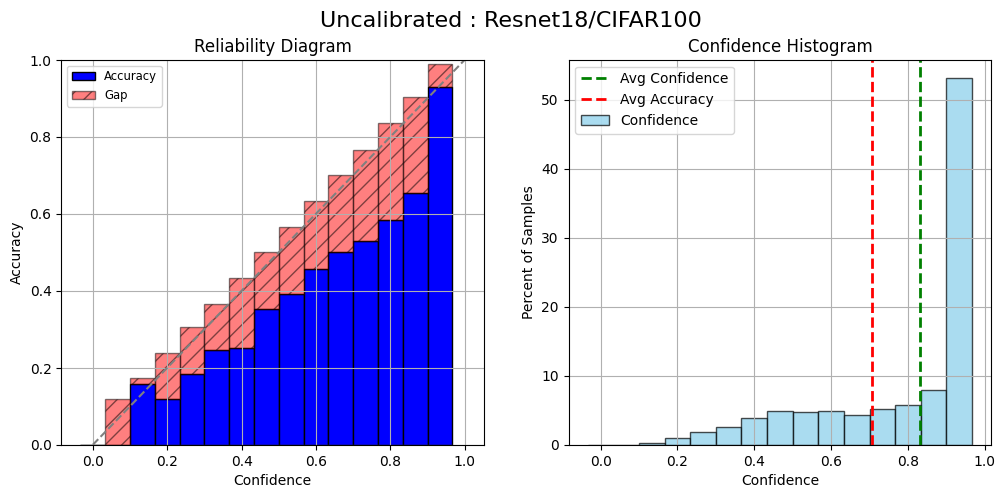

In [213]:
# Uncalibrated Model
probs = F.softmax(all_test_logits, dim=1)
    
# Calculate confidence and predictions
confidences, predictions = probs.max(dim=1)
accuracies = (predictions == all_test_labels).float()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_reliability_diagram(ax1, confidences.numpy(), accuracies.numpy(), n_bins=15)
plot_confidence_histogram(ax2, confidences.numpy(), accuracies.numpy(), n_bins=15)
evaluate(all_test_logits, all_test_labels, n_bins=15, n_classes=100)
fig.suptitle('Uncalibrated : Resnet18/CIFAR100', fontsize=16)

# Observation:

We can see that the "gaps" (defined in terminology) are significantly high for uncalibrated Resnet18. The histogram shows that the model is overconfident on its predictions.

Accuracy: 73.18000197410583%
Error: 26.819998025894165%
ECE: 6.938660889863968%
classwise ECE: 0.1559671713039279%
MCE: 9.231910109519958%
Brier: 0.0038770081795488215


Text(0.5, 0.98, 'Histogram Binning : Resnet18/CIFAR100')

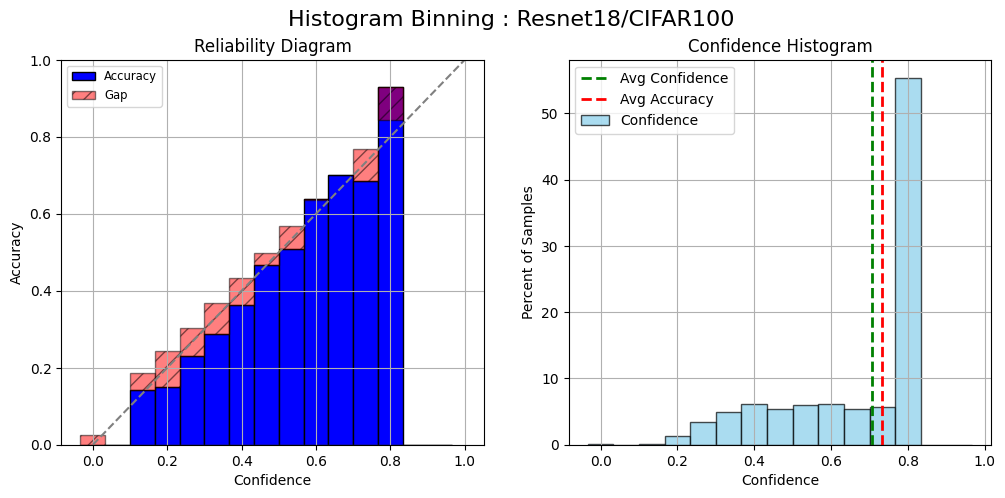

In [214]:
# Histogram Binning on Resnet18 CIFAR100
calibrator = HistogramBinningCalibrator(n_bins=15, n_classes=100)
calibrator.fit(all_test_logits, all_test_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

probs = calibrator.calibrate(all_test_logits)
    
# Calculate confidence and predictions
confidences, predictions = probs.max(dim=1)
accuracies = (predictions == all_test_labels).float()

plot_reliability_diagram(ax1, confidences.numpy(), accuracies.numpy(), n_bins=15)
plot_confidence_histogram(ax2, confidences.numpy(), accuracies.numpy(), n_bins=15)
evaluate(all_test_logits, all_test_labels, probs=probs, n_bins=15, n_classes=100)
fig.suptitle('Histogram Binning : Resnet18/CIFAR100', fontsize=16)

## Observation:

Histogram binning reduces ECE, and the classwise ECE is also reduced significantly, however from the confidence histogram, we can see that the model becomes underconfident even on correct predictions. Observe that the maximum confidence is reduced. Also note that this technique actually boosted the accuracy of the model.

Before temperature - NLL: 1.229, ECE: 0.111
Epoch 0, Loss: 1.0956836938858032
Epoch 100, Loss: 1.0952726602554321
Epoch 200, Loss: 1.0952730178833008
Epoch 300, Loss: 1.0952728986740112
Epoch 400, Loss: 1.0952728986740112
Optimal temperature: 1.535
After temperature - NLL: 1.095, ECE: 0.010
Accuracy: 70.660001039505%
Error: 29.339998960494995%
ECE: 2.7141492813825607%
classwise ECE: 0.18736171768978238%
MCE: 6.601804494857788%
Brier: 0.003961622320234911


Text(0.5, 0.98, 'Temperature Scaling : Resnet18/CIFAR100')

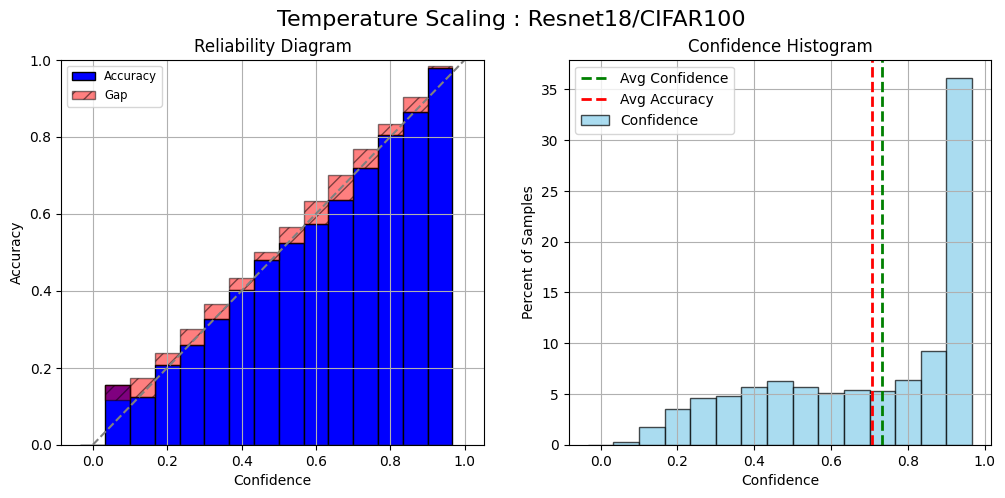

In [215]:
calibrator = TemperatureScalingCalibrator(model)
calibrator.fit(all_valid_logits, all_valid_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

probs = calibrator.calibrate(all_test_logits).cpu().detach()
    
# Calculate confidence and predictions
confidences, predictions = probs.max(dim=1)
accuracies = (predictions == all_test_labels).float()

plot_reliability_diagram(ax1, confidences.numpy(), accuracies.numpy(), n_bins=15)
plot_confidence_histogram(ax2, confidences.numpy(), accuracies.numpy(), n_bins=15)
evaluate(all_test_logits, all_test_labels, probs=probs, n_bins=15, n_classes=100)
fig.suptitle('Temperature Scaling : Resnet18/CIFAR100', fontsize=16)

## Observation:

Temperature Scaling does pretty well and also does not reduce the confidence of the model, it also preserved the accuracy of the model.

Before scaling - NLL: 1.229, ECE: 0.111
Optimal scales: 0.781, 0.712, 0.723, 0.652, 0.662, 0.757, 0.713, 0.667, 0.729, 0.653, 0.700, 0.656, 0.706, 0.731, 0.733, 0.670, 0.679, 0.666, 0.712, 0.713, 0.727, 0.686, 0.664, 0.732, 0.649, 0.694, 0.703, 0.678, 0.723, 0.655, 0.656, 0.676, 0.615, 0.712, 0.687, 0.669, 0.748, 0.685, 0.664, 0.795, 0.695, 0.700, 0.698, 0.699, 0.665, 0.669, 0.715, 0.725, 0.726, 0.770, 0.652, 0.801, 0.754, 0.728, 0.820, 0.667, 0.698, 0.743, 0.696, 0.753, 0.687, 0.681, 0.726, 0.722, 0.738, 0.668, 0.742, 0.683, 0.675, 0.759, 0.753, 0.703, 0.657, 0.733, 0.671, 0.707, 0.690, 0.664, 0.683, 0.749, 0.691, 0.751, 0.756, 0.762, 0.731, 0.740, 0.721, 0.722, 0.766, 0.659, 0.709, 0.716, 0.792, 0.677, 0.706, 0.686, 0.722, 0.697, 0.700, 0.710
After scaling - NLL: 1.070, ECE: 0.020
Accuracy: 70.27000188827515%
Error: 29.729998111724854%
ECE: 5.100424587726593%
classwise ECE: 0.2158530754968524%
MCE: 12.066352367401123%
Brier: 0.004030101157314149


Text(0.5, 0.98, 'Vector Scaling without L2 regularization : Resnet18/CIFAR100')

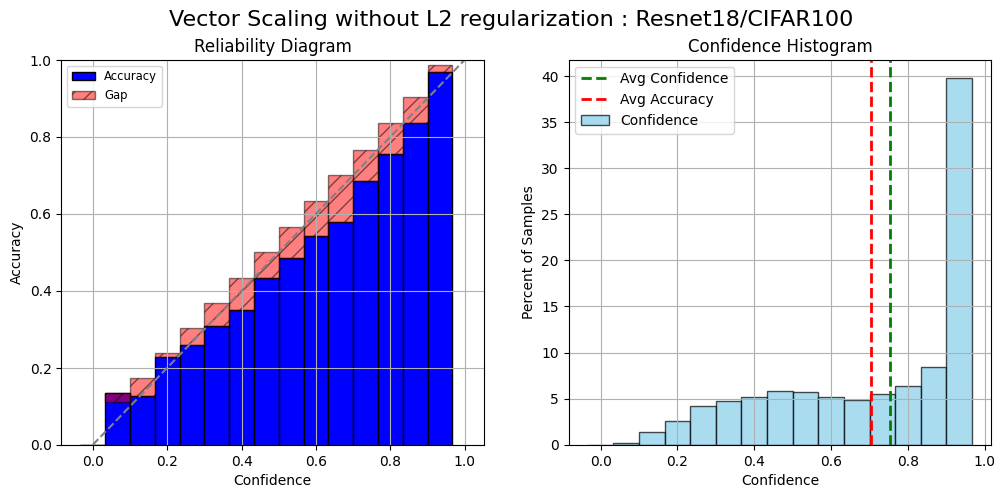

In [216]:
# Vector Scaling
calibrator = VectorScalingCalibrator(model, num_classes=100)

calibrator.fit(all_valid_logits, all_valid_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

probs = calibrator.calibrate(all_test_logits).cpu().detach()
    
# Calculate confidence and predictions
confidences, predictions = probs.max(dim=1)
accuracies = (predictions == all_test_labels).float()

plot_reliability_diagram(ax1, confidences.numpy(), accuracies.numpy(), n_bins=15)
plot_confidence_histogram(ax2, confidences.numpy(), accuracies.numpy(), n_bins=15)
evaluate(all_test_logits, all_test_labels, probs=probs, n_bins=15, n_classes=100)
fig.suptitle('Vector Scaling without L2 regularization : Resnet18/CIFAR100', fontsize=16)

Before scaling - NLL: 1.229, ECE: 0.111
Optimal scales: 0.511, 0.519, 0.510, 0.512, 0.508, 0.516, 0.514, 0.508, 0.505, 0.507, 0.511, 0.508, 0.515, 0.513, 0.509, 0.511, 0.512, 0.510, 0.515, 0.511, 0.509, 0.515, 0.508, 0.515, 0.515, 0.508, 0.511, 0.517, 0.510, 0.508, 0.513, 0.511, 0.510, 0.511, 0.512, 0.510, 0.511, 0.511, 0.516, 0.512, 0.511, 0.506, 0.512, 0.515, 0.512, 0.512, 0.511, 0.509, 0.514, 0.514, 0.513, 0.511, 0.514, 0.512, 0.516, 0.510, 0.509, 0.512, 0.511, 0.511, 0.513, 0.517, 0.510, 0.511, 0.513, 0.514, 0.511, 0.514, 0.515, 0.511, 0.511, 0.511, 0.506, 0.510, 0.511, 0.516, 0.511, 0.514, 0.513, 0.510, 0.512, 0.510, 0.509, 0.516, 0.513, 0.512, 0.515, 0.508, 0.512, 0.512, 0.514, 0.513, 0.506, 0.512, 0.512, 0.512, 0.510, 0.510, 0.510, 0.520
After scaling - NLL: 1.140, ECE: 0.088
Accuracy: 70.81000208854675%
Error: 29.189997911453247%
ECE: 5.1888421177864075%
classwise ECE: 0.2089916029945016%
MCE: 10.500943660736084%
Brier: 0.0039890050715254135


Text(0.5, 0.98, 'Vector Scaling with L2 regularization: Resnet18/CIFAR100')

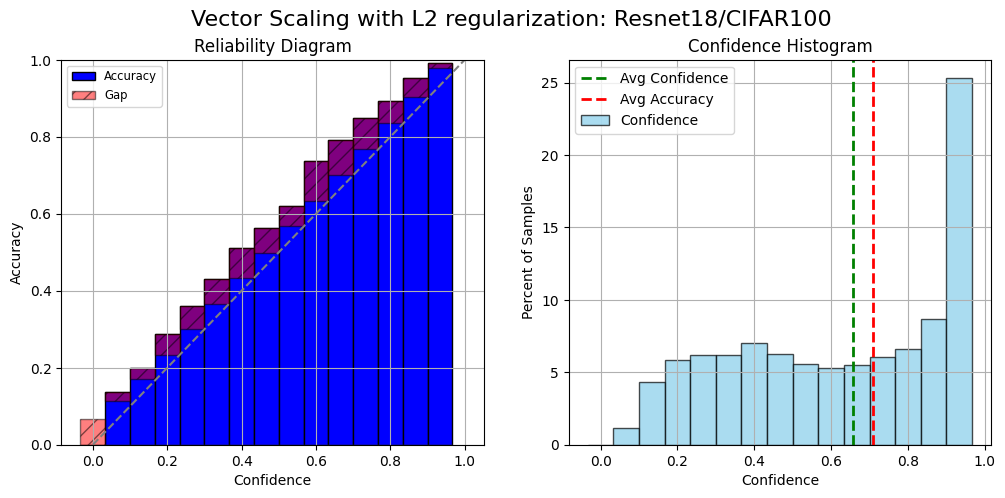

In [217]:
# Vector Scaling
calibrator = VectorScalingCalibrator(model, num_classes=100, regularize=True)

calibrator.fit(all_valid_logits, all_valid_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

probs = calibrator.calibrate(all_test_logits).cpu().detach()
    
# Calculate confidence and predictions
confidences, predictions = probs.max(dim=1)
accuracies = (predictions == all_test_labels).float()

plot_reliability_diagram(ax1, confidences.numpy(), accuracies.numpy(), n_bins=15)
plot_confidence_histogram(ax2, confidences.numpy(), accuracies.numpy(), n_bins=15)
evaluate(all_test_logits, all_test_labels, probs=probs, n_bins=15, n_classes=100)
fig.suptitle('Vector Scaling with L2 regularization: Resnet18/CIFAR100', fontsize=16)

# Observation:

The L2 regularization actually does worse in this case for vector scaling. I think this is because of poor choice of hyperparameters, I think that a good choice of hyperparamters would improve this result.

Before scaling - NLL: 1.229, ECE: 0.111
After scaling - NLL: 0.245, ECE: 0.110
Optimal scales: tensor([[ 1.3046, -0.0392, -0.0204,  ..., -0.2507, -0.0809, -0.1549],
        [-0.1670,  1.2515,  0.1755,  ...,  0.1788,  0.1601,  0.2555],
        [ 0.1219, -0.2150,  1.0217,  ...,  0.2549, -0.0583,  0.2575],
        ...,
        [-0.1023, -0.2621, -0.1628,  ...,  1.0108,  0.2461,  0.1360],
        [-0.1068,  0.0844, -0.0364,  ..., -0.1990,  0.9974, -0.2166],
        [-0.1042, -0.0048, -0.0211,  ...,  0.1660,  0.0560,  1.1153]])
Accuracy: 60.18000245094299%
Error: 39.81999754905701%
ECE: 24.308598041534424%
classwise ECE: 0.5598171148449183%
MCE: 41.134342551231384%
Brier: 0.006197964438600362


Text(0.5, 0.98, 'Matrix Scaling without Regularization : Resnet18/CIFAR100')

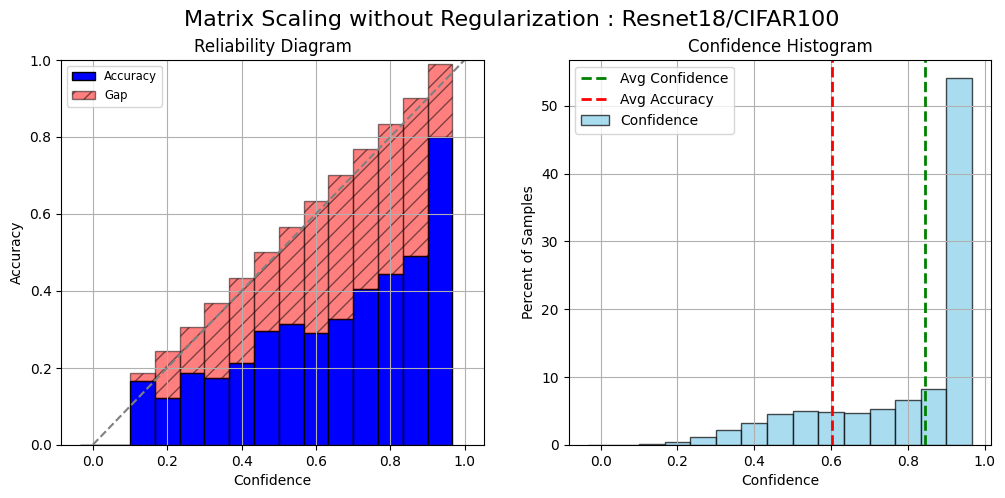

In [218]:
calibrator = MatrixScalingCalibrator(model, num_classes=100)

calibrator.fit(all_valid_logits, all_valid_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

probs = calibrator.calibrate(all_test_logits).cpu().detach()
    
# Calculate confidence and predictions
confidences, predictions = probs.max(dim=1)
accuracies = (predictions == all_test_labels).float()

plot_reliability_diagram(ax1, confidences.numpy(), accuracies.numpy(), n_bins=15)
plot_confidence_histogram(ax2, confidences.numpy(), accuracies.numpy(), n_bins=15)
evaluate(all_test_logits, all_test_labels, probs=probs, n_bins=15, n_classes=100)
fig.suptitle('Matrix Scaling without Regularization : Resnet18/CIFAR100', fontsize=16)

Before scaling - NLL: 1.229, ECE: 0.111
After scaling - NLL: 0.909, ECE: 0.109
Optimal scales: tensor([[ 0.5080, -0.0069,  0.0049,  ..., -0.0151, -0.0108, -0.0088],
        [-0.0068,  0.5121,  0.0057,  ...,  0.0029, -0.0088,  0.0050],
        [ 0.0175, -0.0065,  0.5091,  ...,  0.0007, -0.0035,  0.0049],
        ...,
        [-0.0104, -0.0090,  0.0037,  ...,  0.5107,  0.0151, -0.0119],
        [ 0.0041,  0.0123,  0.0111,  ..., -0.0101,  0.5085, -0.0246],
        [-0.0032,  0.0007, -0.0030,  ..., -0.0021,  0.0043,  0.5125]])
Accuracy: 69.66000199317932%
Error: 30.33999800682068%
ECE: 1.7184365540742874%
classwise ECE: 0.19194756168872118%
MCE: 4.857665300369263%
Brier: 0.004049617927397332


Text(0.5, 0.98, 'Matrix Scaling with L2 Regularization : Resnet18/CIFAR100')

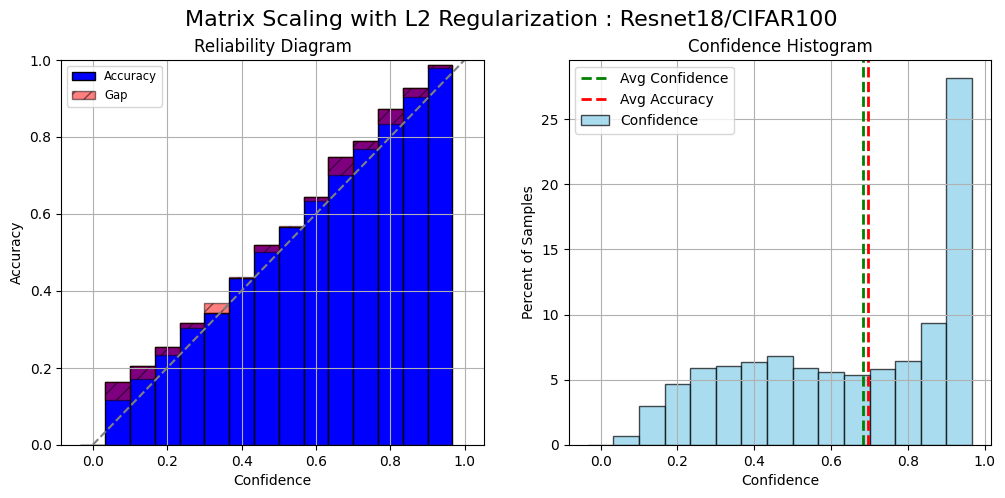

In [219]:
calibrator = MatrixScalingCalibrator(model, num_classes=100, regularize=True)

calibrator.fit(all_valid_logits, all_valid_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

probs = calibrator.calibrate(all_test_logits).cpu().detach()
    
# Calculate confidence and predictions
confidences, predictions = probs.max(dim=1)
accuracies = (predictions == all_test_labels).float()

plot_reliability_diagram(ax1, confidences.numpy(), accuracies.numpy(), n_bins=15)
plot_confidence_histogram(ax2, confidences.numpy(), accuracies.numpy(), n_bins=15)
evaluate(all_test_logits, all_test_labels, probs=probs, n_bins=15, n_classes=100)
fig.suptitle('Matrix Scaling with L2 Regularization : Resnet18/CIFAR100', fontsize=16)

# Observation:

L2 regularization of matrix scaling has the best performance so far. I think the hyperparamters to regularize and avoid overfitting are really important, and is necessary for a good performance of this technique. I think I was able to find(luckily) a fixed hyperparameter which does well.

# Selective Temperature Scaling

Training accuracy of the selector: 1.000
Before temperature - NLL: 1.229, ECE: 0.111
Optimal temperatures - Correct: 1.000, Incorrect: 1.397
After temperature - NLL: 1.034, ECE: 0.074
Accuracy: 70.660001039505%
Error: 29.339998960494995%
ECE: 10.007542371749878%
classwise ECE: 0.27705985121428967%
MCE: 23.54983687400818%
Brier: 0.004141745431985225


Text(0.5, 0.98, 'Selective Temperature Scaling : Resnet18/CIFAR100')

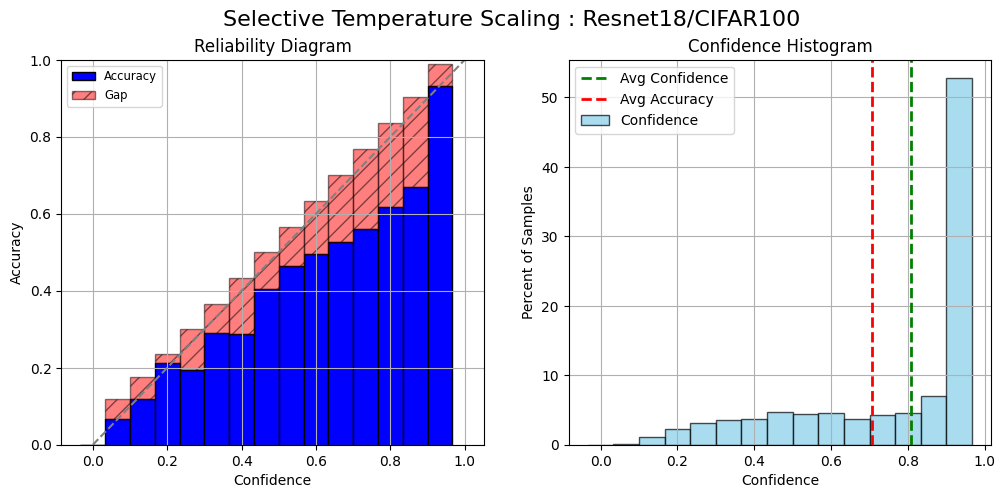

In [220]:
classifier = train_binary_classifier(all_valid_logits, all_valid_labels)
calibrator = SelectiveTemperatureScalingCalibrator(model, classifier)

calibrator.fit(all_valid_logits, all_valid_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

probs = calibrator.calibrate(all_test_logits).cpu().detach()
    
# Calculate confidence and predictions
confidences, predictions = probs.max(dim=1)
accuracies = (predictions == all_test_labels).float()

plot_reliability_diagram(ax1, confidences.numpy(), accuracies.numpy(), n_bins=15)
plot_confidence_histogram(ax2, confidences.numpy(), accuracies.numpy(), n_bins=15)
evaluate(all_test_logits, all_test_labels, probs=probs, n_bins=15, n_classes=100)
fig.suptitle('Selective Temperature Scaling : Resnet18/CIFAR100', fontsize=16)

# Observation:

I think that the selective scaling technique is only useful as suggested in the paper: https://arxiv.org/pdf/2212.12053, when the source of miscalibration is mostly misprediction which is not the case here I'm assuming.

# Experiments with Resnet34 on CIFAR-100

In [221]:
# Load trained model
model = get_resnet34_model(num_classes=100)
model.load_state_dict(torch.load('./trained_models/resnet34_cifar100.pth')["state_dict"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

C:\Users\utkar\OneDrive\Desktop\UW\cs484\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\utkar\OneDrive\Desktop\UW\cs484\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [222]:
# Load test set
test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform_cifar100)
test_loader = torch.utils.data.DataLoader(test_set, pin_memory=True, batch_size=64)

all_test_logits = []
all_test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        all_test_logits.append(outputs)
        all_test_labels.append(labels)

# Concatenate all batches
all_test_logits = torch.cat(all_test_logits, dim=0).cpu()
all_test_labels = torch.cat(all_test_labels, dim=0).cpu()

Files already downloaded and verified


In [223]:
# load validation set
train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform_cifar100)
valid_idxs = torch.load("./trained_models/valid_indices_resnet34_cifar100.pth")
if valid_idxs.is_cuda:
    valid_idxs = valid_idxs.cpu()
valid_idxs_list = valid_idxs.tolist()
valid_set = torch.utils.data.Subset(train_set, valid_idxs_list)
valid_loader = torch.utils.data.DataLoader(valid_set, pin_memory=True, batch_size=64)

all_valid_logits = []
all_valid_labels = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        all_valid_logits.append(outputs)
        all_valid_labels.append(labels)

# Concatenate all batches
all_valid_logits = torch.cat(all_valid_logits, dim=0).cpu()
all_valid_labels = torch.cat(all_valid_labels, dim=0).cpu()

Files already downloaded and verified


Accuracy: 70.24000287055969%
Error: 29.759997129440308%
ECE: 15.452712774276733%
classwise ECE: 0.3740261308848858%
MCE: 32.08032250404358%
Brier: 0.004472035683174787


Text(0.5, 0.98, 'Uncalibrated : Resnet34/CIFAR100')

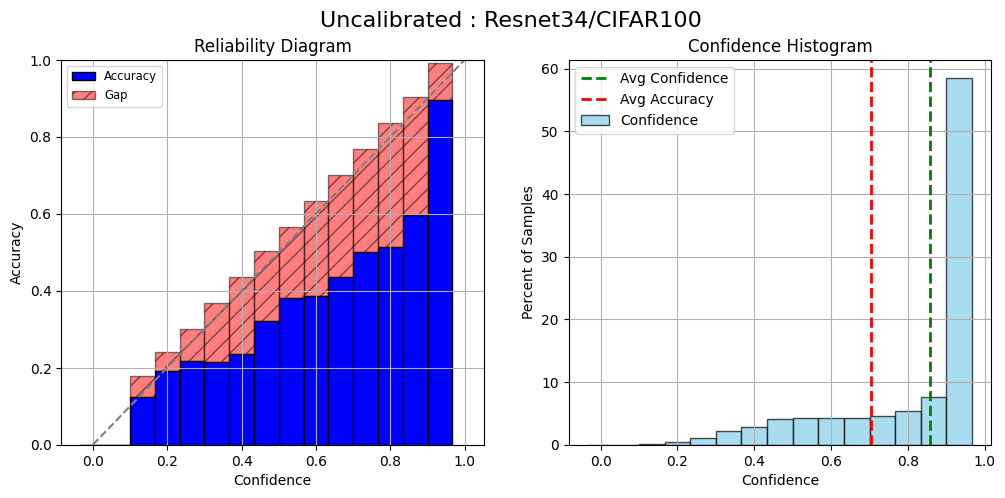

In [224]:
# Uncalibrated Model
probs = F.softmax(all_test_logits, dim=1)
    
# Calculate confidence and predictions
confidences, predictions = probs.max(dim=1)
accuracies = (predictions == all_test_labels).float()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_reliability_diagram(ax1, confidences.numpy(), accuracies.numpy(), n_bins=15)
plot_confidence_histogram(ax2, confidences.numpy(), accuracies.numpy(), n_bins=15)
evaluate(all_test_logits, all_test_labels, n_bins=15, n_classes=100)
fig.suptitle('Uncalibrated : Resnet34/CIFAR100', fontsize=16)

# Observation:

Note that the miscalibration as measured by the ECE for Resnet34 is higher than Resnet18. This is expeceted because resnet24 is a deeper network and the original paper shows that more complex CNNs are more prone to miscalibration.

Accuracy: 73.36000204086304%
Error: 26.639997959136963%
ECE: 6.709320843219757%
classwise ECE: 0.15526774805039167%
MCE: 18.808352947235107%
Brier: 0.003967777597076202


Text(0.5, 0.98, 'Histogram Binning : Resnet34/CIFAR100')

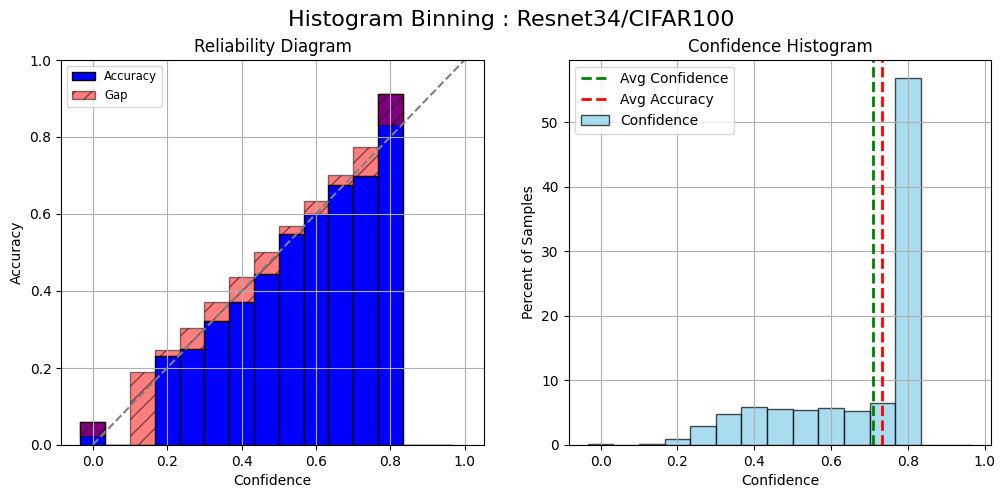

In [225]:
# Histogram Binning on Resnet34 CIFAR100
calibrator = HistogramBinningCalibrator(n_bins=15, n_classes=100)
calibrator.fit(all_test_logits, all_test_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

probs = calibrator.calibrate(all_test_logits)
    
# Calculate confidence and predictions
confidences, predictions = probs.max(dim=1)
accuracies = (predictions == all_test_labels).float()

plot_reliability_diagram(ax1, confidences.numpy(), accuracies.numpy(), n_bins=15)
plot_confidence_histogram(ax2, confidences.numpy(), accuracies.numpy(), n_bins=15)
evaluate(all_test_logits, all_test_labels, probs=probs, n_bins=15, n_classes=100)
fig.suptitle('Histogram Binning : Resnet34/CIFAR100', fontsize=16)

# Observation:

Histogram Binning performs similar to Resnet18 above with underconfident predictions after calibrations as expected from observations before.

Before temperature - NLL: 1.424, ECE: 0.154
Epoch 0, Loss: 1.1600290536880493
Epoch 100, Loss: 1.1418139934539795
Epoch 200, Loss: 1.131590485572815
Epoch 300, Loss: 1.1261440515518188
Epoch 400, Loss: 1.1234132051467896
Optimal temperature: 1.810
After temperature - NLL: 1.122, ECE: 0.016
Accuracy: 70.24000287055969%
Error: 29.759997129440308%
ECE: 2.813529781997204%
classwise ECE: 0.19148868741467595%
MCE: 6.647482514381409%
Brier: 0.004023624317173378


Text(0.5, 0.98, 'Temperature Scaling : Resnet34/CIFAR100')

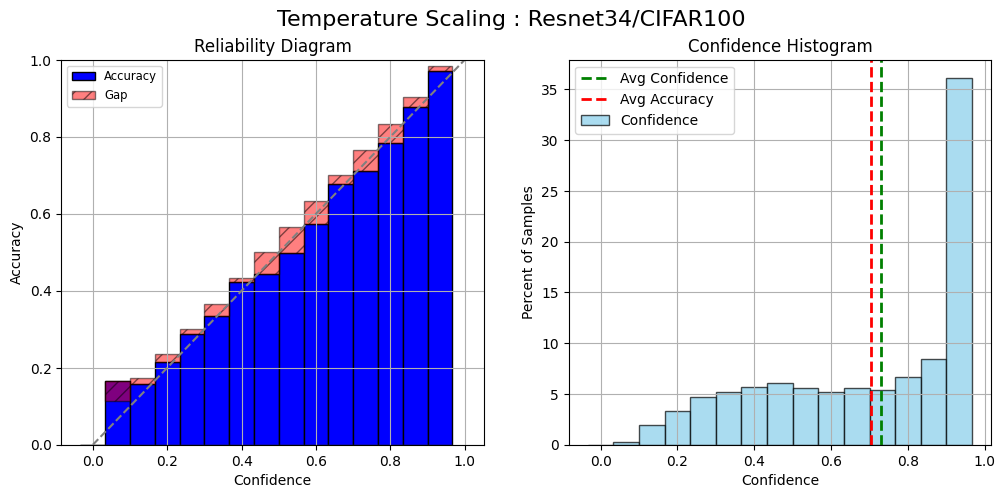

In [226]:
calibrator = TemperatureScalingCalibrator(model)
calibrator.fit(all_valid_logits, all_valid_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

probs = calibrator.calibrate(all_test_logits).cpu().detach()
    
# Calculate confidence and predictions
confidences, predictions = probs.max(dim=1)
accuracies = (predictions == all_test_labels).float()

plot_reliability_diagram(ax1, confidences.numpy(), accuracies.numpy(), n_bins=15)
plot_confidence_histogram(ax2, confidences.numpy(), accuracies.numpy(), n_bins=15)
evaluate(all_test_logits, all_test_labels, probs=probs, n_bins=15, n_classes=100)
fig.suptitle('Temperature Scaling : Resnet34/CIFAR100', fontsize=16)

# Observation:

Temperature Scaling performs similarly to Resnet18, we compare the ECE losses in the compiled results below.

Before scaling - NLL: 1.424, ECE: 0.154
Optimal scales: 0.618, 0.666, 0.587, 0.608, 0.593, 0.612, 0.615, 0.596, 0.694, 0.694, 0.607, 0.599, 0.619, 0.640, 0.585, 0.696, 0.633, 0.618, 0.617, 0.614, 0.691, 0.615, 0.617, 0.630, 0.603, 0.615, 0.579, 0.625, 0.601, 0.624, 0.588, 0.642, 0.577, 0.619, 0.602, 0.576, 0.633, 0.697, 0.609, 0.600, 0.631, 0.597, 0.584, 0.627, 0.602, 0.620, 0.590, 0.626, 0.658, 0.678, 0.583, 0.601, 0.616, 0.609, 0.675, 0.600, 0.622, 0.593, 0.652, 0.614, 0.599, 0.705, 0.614, 0.633, 0.579, 0.576, 0.564, 0.580, 0.658, 0.607, 0.675, 0.602, 0.591, 0.624, 0.590, 0.661, 0.614, 0.615, 0.621, 0.611, 0.571, 0.637, 0.643, 0.639, 0.703, 0.615, 0.633, 0.622, 0.628, 0.634, 0.665, 0.617, 0.630, 0.608, 0.660, 0.609, 0.635, 0.576, 0.570, 0.594
After scaling - NLL: 1.107, ECE: 0.043
Accuracy: 70.34000158309937%
Error: 29.659998416900635%
ECE: 5.93516007065773%
classwise ECE: 0.22967203985899687%
MCE: 11.185169219970703%
Brier: 0.004083180892194103


Text(0.5, 0.98, 'Vector Scaling without L2 regularization: Resnet34/CIFAR100')

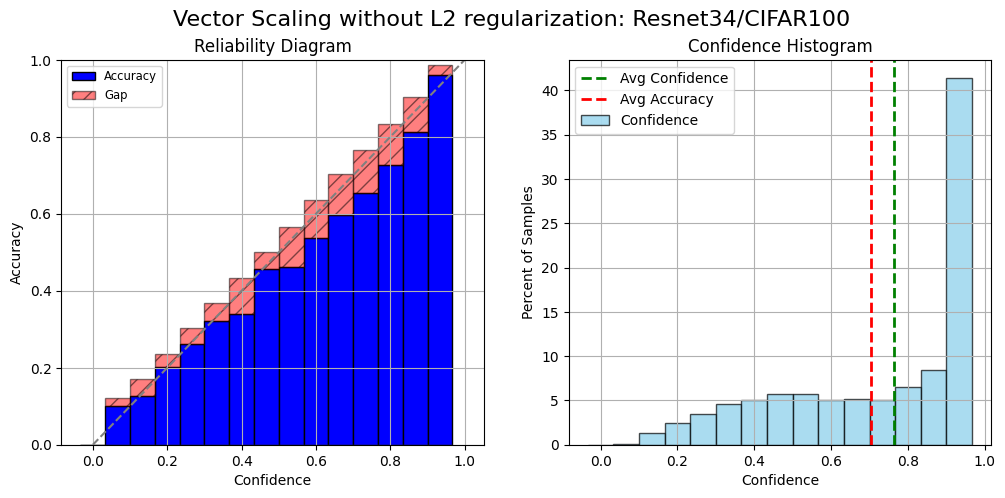

In [227]:
# Vector Scaling
calibrator = VectorScalingCalibrator(model, num_classes=100)

calibrator.fit(all_valid_logits, all_valid_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

probs = calibrator.calibrate(all_test_logits).cpu().detach()
    
# Calculate confidence and predictions
confidences, predictions = probs.max(dim=1)
accuracies = (predictions == all_test_labels).float()

plot_reliability_diagram(ax1, confidences.numpy(), accuracies.numpy(), n_bins=15)
plot_confidence_histogram(ax2, confidences.numpy(), accuracies.numpy(), n_bins=15)
evaluate(all_test_logits, all_test_labels, probs=probs, n_bins=15, n_classes=100)
fig.suptitle('Vector Scaling without L2 regularization: Resnet34/CIFAR100', fontsize=16)

Before scaling - NLL: 1.424, ECE: 0.154
Optimal scales: 0.507, 0.515, 0.513, 0.508, 0.512, 0.510, 0.513, 0.506, 0.511, 0.509, 0.507, 0.508, 0.507, 0.509, 0.513, 0.518, 0.512, 0.510, 0.511, 0.509, 0.509, 0.509, 0.511, 0.511, 0.511, 0.509, 0.509, 0.514, 0.507, 0.503, 0.506, 0.511, 0.511, 0.508, 0.513, 0.508, 0.513, 0.508, 0.512, 0.510, 0.506, 0.505, 0.506, 0.509, 0.512, 0.511, 0.509, 0.502, 0.511, 0.509, 0.509, 0.510, 0.510, 0.504, 0.514, 0.505, 0.510, 0.503, 0.505, 0.508, 0.510, 0.513, 0.503, 0.506, 0.510, 0.513, 0.505, 0.508, 0.509, 0.508, 0.504, 0.508, 0.505, 0.516, 0.511, 0.513, 0.508, 0.511, 0.510, 0.509, 0.510, 0.506, 0.508, 0.510, 0.502, 0.511, 0.509, 0.513, 0.507, 0.510, 0.513, 0.512, 0.504, 0.509, 0.511, 0.509, 0.503, 0.509, 0.507, 0.512
After scaling - NLL: 1.121, ECE: 0.019
Accuracy: 70.31000256538391%
Error: 29.68999743461609%
ECE: 1.0899036191403866%
classwise ECE: 0.18344890559092164%
MCE: 7.062026858329773%
Brier: 0.004008344822753498


Text(0.5, 0.98, 'Vector Scaling with L2 Regularization: Resnet34/CIFAR100')

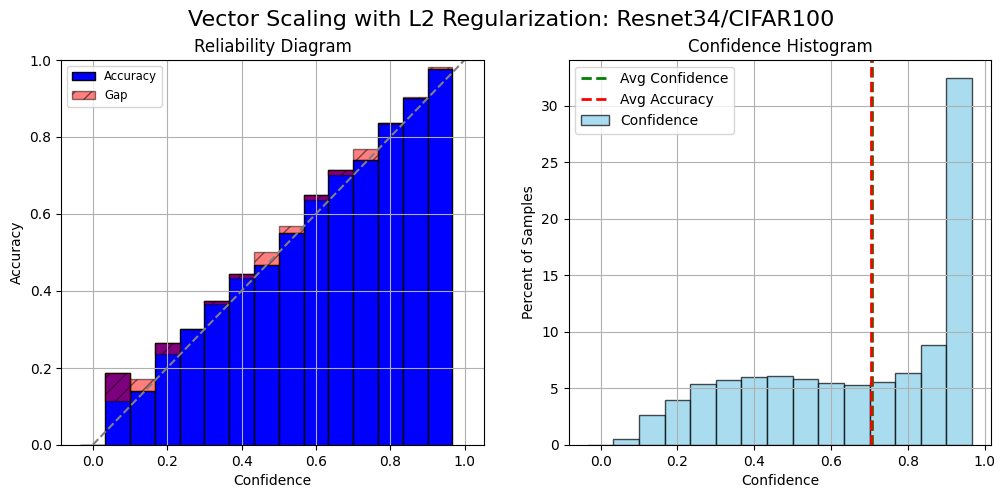

In [228]:
# Vector Scaling
calibrator = VectorScalingCalibrator(model, num_classes=100, regularize=True)

calibrator.fit(all_valid_logits, all_valid_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

probs = calibrator.calibrate(all_test_logits).cpu().detach()
    
# Calculate confidence and predictions
confidences, predictions = probs.max(dim=1)
accuracies = (predictions == all_test_labels).float()

plot_reliability_diagram(ax1, confidences.numpy(), accuracies.numpy(), n_bins=15)
plot_confidence_histogram(ax2, confidences.numpy(), accuracies.numpy(), n_bins=15)
evaluate(all_test_logits, all_test_labels, probs=probs, n_bins=15, n_classes=100)
fig.suptitle('Vector Scaling with L2 Regularization: Resnet34/CIFAR100', fontsize=16)

# Interesting Observation:

Vector Scaling with regularization performs better than temperature scaling!!!

I think this can be attributed to correct hyperparamter choice for regularization. This difference from Resnet18 shows the importance of that choice in my opinion.

Before scaling - NLL: 1.424, ECE: 0.154
After scaling - NLL: 0.255, ECE: 0.103
Optimal scales: tensor([[ 1.0814, -0.1441, -0.2794,  ...,  0.3439, -0.2338, -0.2333],
        [-0.1576,  1.0563, -0.1029,  ...,  0.1876,  0.0735,  0.0863],
        [-0.1710,  0.2957,  0.8553,  ...,  0.1295, -0.3021,  0.0716],
        ...,
        [ 0.1990, -0.2036, -0.2856,  ...,  0.8933, -0.1435, -0.0233],
        [ 0.2380, -0.0660,  0.1390,  ..., -0.0408,  0.8501, -0.0358],
        [ 0.1491, -0.2097, -0.2044,  ...,  0.0951, -0.0984,  0.9682]])
Accuracy: 60.08999943733215%
Error: 39.91000056266785%
ECE: 24.713288247585297%
classwise ECE: 0.5703883711248636%
MCE: 43.0605411529541%
Brier: 0.00622181911353512


Text(0.5, 0.98, 'Matrix Scaling without Regularization : Resnet34/CIFAR100')

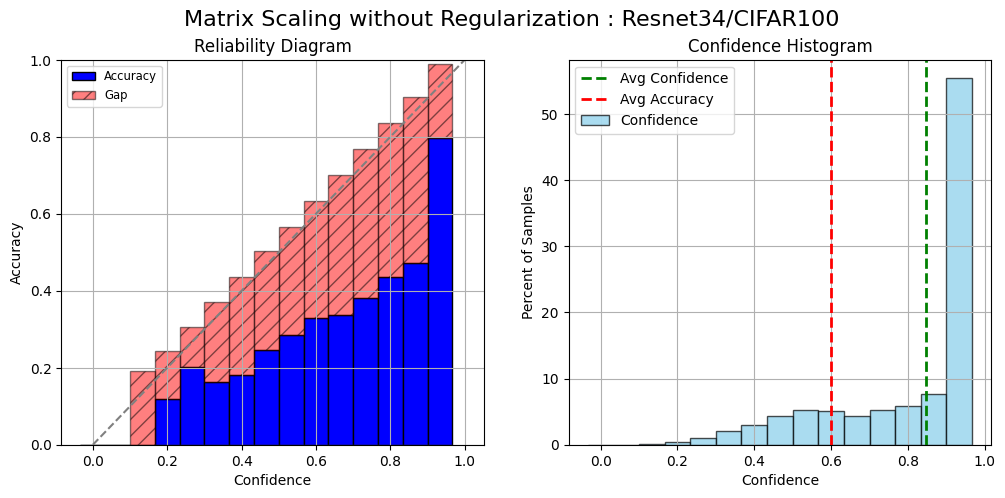

In [229]:
calibrator = MatrixScalingCalibrator(model, num_classes=100)

calibrator.fit(all_valid_logits, all_valid_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

probs = calibrator.calibrate(all_test_logits).cpu().detach()
    
# Calculate confidence and predictions
confidences, predictions = probs.max(dim=1)
accuracies = (predictions == all_test_labels).float()

plot_reliability_diagram(ax1, confidences.numpy(), accuracies.numpy(), n_bins=15)
plot_confidence_histogram(ax2, confidences.numpy(), accuracies.numpy(), n_bins=15)
evaluate(all_test_logits, all_test_labels, probs=probs, n_bins=15, n_classes=100)
fig.suptitle('Matrix Scaling without Regularization : Resnet34/CIFAR100', fontsize=16)

Before scaling - NLL: 1.424, ECE: 0.154
After scaling - NLL: 0.876, ECE: 0.066
Optimal scales: tensor([[ 0.5068, -0.0100, -0.0024,  ...,  0.0071, -0.0093, -0.0051],
        [-0.0071,  0.5090,  0.0016,  ..., -0.0048,  0.0045,  0.0164],
        [-0.0050,  0.0024,  0.5090,  ...,  0.0055, -0.0042, -0.0018],
        ...,
        [ 0.0023, -0.0190, -0.0204,  ...,  0.5093, -0.0124,  0.0035],
        [ 0.0010,  0.0074,  0.0095,  ...,  0.0075,  0.5095, -0.0056],
        [ 0.0087,  0.0027,  0.0058,  ...,  0.0014, -0.0136,  0.5112]])
Accuracy: 69.37000155448914%
Error: 30.629998445510864%
ECE: 2.762269973754883%
classwise ECE: 0.20536829251796007%
MCE: 8.58696699142456%
Brier: 0.004116538232046614


Text(0.5, 0.98, 'Matrix Scaling with Regularization : Resnet34/CIFAR100')

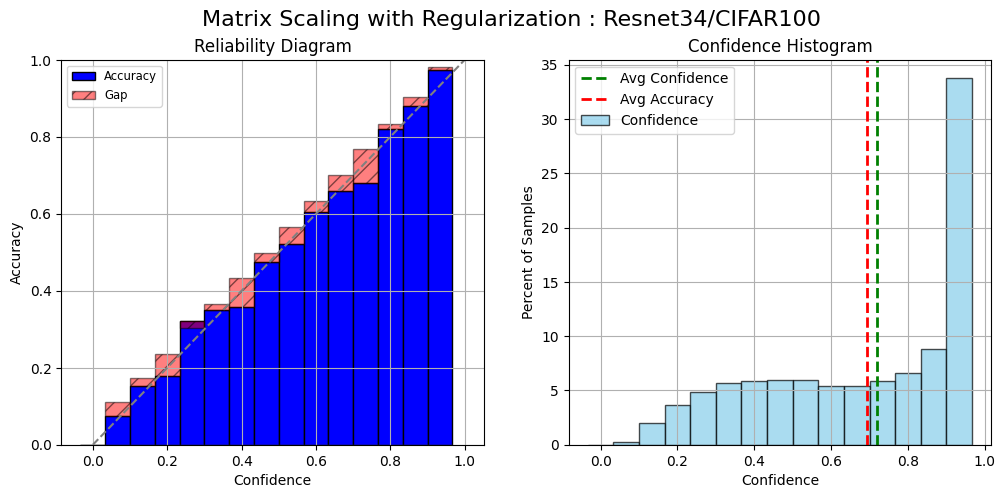

In [230]:
calibrator = MatrixScalingCalibrator(model, num_classes=100, regularize=True)

calibrator.fit(all_valid_logits, all_valid_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

probs = calibrator.calibrate(all_test_logits).cpu().detach()
    
# Calculate confidence and predictions
confidences, predictions = probs.max(dim=1)
accuracies = (predictions == all_test_labels).float()

plot_reliability_diagram(ax1, confidences.numpy(), accuracies.numpy(), n_bins=15)
plot_confidence_histogram(ax2, confidences.numpy(), accuracies.numpy(), n_bins=15)
evaluate(all_test_logits, all_test_labels, probs=probs, n_bins=15, n_classes=100)
fig.suptitle('Matrix Scaling with Regularization : Resnet34/CIFAR100', fontsize=16)

# Observation:

Matrix Scaling without regularization highly overfits to the validation set, this happens because the number of parameters is $100*100 + 100 = 10100$ which is significantly high for a validation set of 5000, L2 regularization helps a lot and overcomes this overfitting, we see that matrix scaling performing similarly to temperature scaling. However, the accuracy is affected by this technique.

Training accuracy of the selector: 1.000
Before temperature - NLL: 1.424, ECE: 0.154
Optimal temperatures - Correct: 1.000, Incorrect: 1.407
After temperature - NLL: 1.135, ECE: 0.120
Accuracy: 70.24000287055969%
Error: 29.759997129440308%
ECE: 12.705759704113007%
classwise ECE: 0.32448137644678354%
MCE: 25.827115774154663%
Brier: 0.004321813726289695


Text(0.5, 0.98, 'Selective Temperature Scaling : Resnet34/CIFAR100')

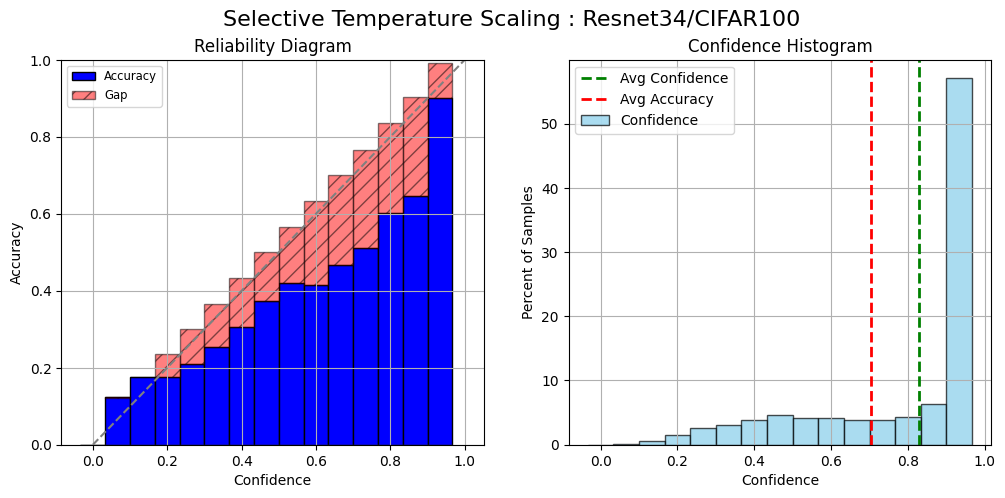

In [231]:
classifier = train_binary_classifier(all_valid_logits, all_valid_labels)
calibrator = SelectiveTemperatureScalingCalibrator(model, classifier)

calibrator.fit(all_valid_logits, all_valid_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

probs = calibrator.calibrate(all_test_logits).cpu().detach()
    
# Calculate confidence and predictions
confidences, predictions = probs.max(dim=1)
accuracies = (predictions == all_test_labels).float()

plot_reliability_diagram(ax1, confidences.numpy(), accuracies.numpy(), n_bins=15)
plot_confidence_histogram(ax2, confidences.numpy(), accuracies.numpy(), n_bins=15)
evaluate(all_test_logits, all_test_labels, probs=probs, n_bins=15, n_classes=100)
fig.suptitle('Selective Temperature Scaling : Resnet34/CIFAR100', fontsize=16)

# Compiled Results:

In [232]:
data_resnet18 = np.array([
    [70.660001, 29.339999, 12.371464, 0.316330, 25.148910, 0.0042418],    # Uncalibrated
    [73.180002, 26.820000, 6.938661, 0.155967, 9.231910, 0.0038770],      # Histogram Binning
    [70.660001, 29.339999, 2.782123, 0.188127, 7.379353, 0.0039624],      # Temperature Scaling
    [70.160002, 29.839998, 5.044569, 0.210942, 11.521226, 0.0040187],     # Vector Scaling without regularization
    [70.749998, 29.250002, 5.099803, 0.210142, 9.742123, 0.0039899],      # Vector Scaling with regularization
    [59.479999, 40.520000, 24.715227, 0.571487, 43.011743, 0.0062765],    # Matrix Scaling without regularization
    [69.499999, 30.500001, 1.893206, 0.189056, 5.798453, 0.0040381],       # Matrix Scaling with regularization
    [70.660001, 29.339999, 9.823789, 0.274057, 23.822844, 0.0041389]      # Selective scaling
])

index_resnet18 = [
    'Uncalibrated', 'Histogram Binning', 'Temperature Scaling',
    'Vector Scaling without regularization', 'Vector Scaling with regularization',
    'Matrix Scaling without regularization', 'Matrix Scaling with regularization', 'Selective Temperature Scaling'
]

columns = ['Accuracy (%)', 'Error (%)', 'ECE (%)', 'Classwise ECE (%)', 'MCE (%)', 'Brier']

# Create DataFrame
df_resnet18 = pd.DataFrame(data_resnet18, index=index_resnet18, columns=columns)

# Display the DataFrame
print(df_resnet18)

                                       Accuracy (%)  Error (%)    ECE (%)  \
Uncalibrated                              70.660001  29.339999  12.371464   
Histogram Binning                         73.180002  26.820000   6.938661   
Temperature Scaling                       70.660001  29.339999   2.782123   
Vector Scaling without regularization     70.160002  29.839998   5.044569   
Vector Scaling with regularization        70.749998  29.250002   5.099803   
Matrix Scaling without regularization     59.479999  40.520000  24.715227   
Matrix Scaling with regularization        69.499999  30.500001   1.893206   
Selective Temperature Scaling             70.660001  29.339999   9.823789   

                                       Classwise ECE (%)    MCE (%)     Brier  
Uncalibrated                                    0.316330  25.148910  0.004242  
Histogram Binning                               0.155967   9.231910  0.003877  
Temperature Scaling                             0.188127   7.37935

In [233]:
# Update data array to include new techniques for ResNet-34
data_resnet34 = np.array([
    [70.240003, 29.760000, 15.452713, 0.374026, 32.080323, 0.0044720],    # Uncalibrated
    [73.360002, 26.640000, 6.709321, 0.155268, 18.808353, 0.0039678],     # Histogram Binning
    [70.240003, 29.760000, 2.927009, 0.191734, 7.088417, 0.0040247],      # Temperature Scaling
    [70.300001, 29.700000, 6.418398, 0.231423, 12.470007, 0.0040968],     # Vector Scaling without regularization
    [70.289999, 29.710001, 0.867080, 0.184730, 5.896054, 0.0040094],      # Vector Scaling with regularization
    [59.719998, 40.280002, 25.226730, 0.575301, 44.305801, 0.0063173],    # Matrix Scaling without regularization
    [69.580001, 30.420000, 2.594226, 0.205495, 9.008213, 0.0041272],       # Matrix Scaling with regularization
    [70.240003, 29.760000, 12.709409, 0.326200, 27.792132, 0.0043253]     # selective temperature scaling

])

index_resnet34 = [
    'Uncalibrated', 'Histogram Binning', 'Temperature Scaling',
    'Vector Scaling without regularization', 'Vector Scaling with regularization',
    'Matrix Scaling without regularization', 'Matrix Scaling with regularization', 'Selective Temperature Scaling'
]

# Create DataFrame
df_resnet34 = pd.DataFrame(data_resnet34, index=index_resnet34, columns=columns)

# Display the DataFrame
print(df_resnet34)


                                       Accuracy (%)  Error (%)    ECE (%)  \
Uncalibrated                              70.240003  29.760000  15.452713   
Histogram Binning                         73.360002  26.640000   6.709321   
Temperature Scaling                       70.240003  29.760000   2.927009   
Vector Scaling without regularization     70.300001  29.700000   6.418398   
Vector Scaling with regularization        70.289999  29.710001   0.867080   
Matrix Scaling without regularization     59.719998  40.280002  25.226730   
Matrix Scaling with regularization        69.580001  30.420000   2.594226   
Selective Temperature Scaling             70.240003  29.760000  12.709409   

                                       Classwise ECE (%)    MCE (%)     Brier  
Uncalibrated                                    0.374026  32.080323  0.004472  
Histogram Binning                               0.155268  18.808353  0.003968  
Temperature Scaling                             0.191734   7.08841

# Conclusion

I explored a bunch of post-training calibration techniques, found that temperature scaling is the most robust technique to fix miscalibration if we just consider ECE as the metric. The classwise ECE is best lowered by Histogram Binning in both cases (Resnet18 and Resnet34). Temperature Scaling is better in my opinion because we don't effect the model accuracy at all. Histogram binning does effect the model accuracy, in our case it actually boosted the accuracy. However, it remains to be tested if it always boosts the accuracy of the model.

The new regularization techniques for vector/matrix scaling actually helps it perform better than temperature scaling, given that the hyperparameters are tuned properly. However, the accuracy of the model is slighltly lowered in both these cases(see above). Next steps would be to look into the hyper-parameter tuning of the regularization techniques and testing out the model accuracy degradation using vector/matrix scaling. If it is not too high, then this can be consider over temperature scaling in these scenarios.

For Resnet34: \
Temperature Scaling                         2.927009 (ECE%) \
Matrix Scaling with regularization          2.594226 (ECE%) \
**Vector Scaling with regularization        0.867080 (ECE%)**

For Resnet18:\
Temperature Scaling                         2.782123 (ECE%) \
Vector Scaling with regularization          5.099803 (ECE%) \
**Matrix Scaling with regularization        1.893206 (ECE%)**

**MCE is also lower for these regularized matrix/vector scaling techniques**

It also remains to be looked on why the classwise ECE % for these techniques are worse than histogram binning.

I mostly looked at post-training calibration techniques, there are also techniques which improve calibration during training. There are also some other post-calibration techniques which I was unable to implement due to lack of time.

1. Dirichlet Scaling: Paper- https://arxiv.org/pdf/1910.12656
2. Spline Fitting:    Paper- https://proceedings.neurips.cc/paper_files/paper/2021/file/61f3a6dbc9120ea78ef75544826c814e-Paper.pdf

Both of these are promising and show better performance than temperature scaling, next steps would be to look into these and compare to regularized vector/matrix scaling.

# References:



1. https://arxiv.org/pdf/1706.04599
2. https://arxiv.org/pdf/2212.12053
3. https://arxiv.org/pdf/1910.12656
4. https://github.com/gpleiss/temperature_scaling/tree/master